<a href="https://colab.research.google.com/github/Telemaco019/flower_recognition/blob/master/tf_flowers_complete_xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup environment


In [0]:
#import plaidml.keras
#import os

# For using AMD GPU
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
#plaidml.keras.install_backend()

In [1]:
# Switch version to 2.x (works only in Colab)
%tensorflow_version 2.x 

TensorFlow 2.x selected.


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"telemaco019","key":"5922d86fb39ad01ab029d7931d9fbd00"}'}

In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!cat ~/.kaggle/kaggle.json

{"username":"telemaco019","key":"5922d86fb39ad01ab029d7931d9fbd00"}

In [5]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 96% 433M/450M [00:10<00:00, 28.7MB/s]
100% 450M/450M [00:10<00:00, 46.6MB/s]


In [6]:
!unzip /content/flowers-recognition.zip 

Archive:  /content/flowers-recognition.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.

# Constants and imports


In [7]:
import glob
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from functools import partial 
import os 


Using TensorFlow backend.


In [8]:
import tensorflow as tf
print(tf.__version__)

DATASET_ROOT_DIR = '/content/flowers'

DAISY_DIR = 'daisy'
DANDELION_DIR = 'dandelion'
ROSE_DIR = 'rose'
SUNFLOWER_DIR = 'sunflower'

DATA_DIRS = [DAISY_DIR, DANDELION_DIR, ROSE_DIR, SUNFLOWER_DIR]

BATCH_SIZE = 32
IMG_SIZE = 224
SEED = 42
AUTOTUNE = tf.data.experimental.AUTOTUNE

2.1.0-rc1


# Load and prepare dataset

In [0]:
def load_data(dataset_directory): 
    images = []
    labels = []
    complete_directory = "{}/{}".format(DATASET_ROOT_DIR, dataset_directory)
    print('Loading data from: {}/'.format(complete_directory))

    for img_file in tqdm(os.listdir(complete_directory)):
        path = os.path.join(complete_directory, img_file)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        if not img is None: 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # change color channels order
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            images.append(np.array(img))
            labels.append(str(dataset_directory))
    
    return (np.array(images), np.array(labels))

In [0]:
encoder = LabelEncoder()
def encode_labels(string_labels):
    return encoder.fit_transform(string_labels)


In [0]:
def load_dataset():
    X = []
    Z = []
  
    for directory in DATA_DIRS:
        (data, labels_strings) = load_data(directory) 
        X.append(data)
        Z.append(labels_strings)
        
    # Squeeze into 1d array
    X = np.concatenate(X, axis=0)
    Z = np.concatenate(Z, axis=0)
    
    # Encode labels
    Y = encode_labels(Z)
    
    return (X,Y)

In [12]:
(X,Y) = load_dataset()

  3%|▎         | 20/769 [00:00<00:03, 195.89it/s]

Loading data from: /content/flowers/daisy/


  4%|▍         | 47/1055 [00:00<00:02, 464.55it/s]

Loading data from: /content/flowers/dandelion/


  5%|▌         | 40/784 [00:00<00:01, 399.71it/s]

Loading data from: /content/flowers/rose/


  5%|▍         | 36/734 [00:00<00:01, 358.92it/s]

Loading data from: /content/flowers/sunflower/


100%|██████████| 734/734 [00:02<00:00, 346.15it/s]


In [13]:
print("Total number of images: {}".format(len(X)))
print("Total number of labels: {}".format(len(Y)))

Total number of images: 3339
Total number of labels: 3339


**Split train, valid and test datasets**

In [14]:
from sklearn import model_selection

X_train, X_test_valid, Y_train, Y_test_valid = model_selection.train_test_split(X,Y, train_size=0.75)
X_valid, X_test, Y_valid, Y_test = model_selection.train_test_split(X_test_valid, Y_test_valid, train_size=0.75)

print("Training dataset size: {}".format(len(X_train)))
print("Validation dataset size: {}".format(len(X_valid)))
print("Test dataset size: {}".format(len(X_test)))

Training dataset size: 2504
Validation dataset size: 626
Test dataset size: 209


# Utility functions


## Plot

In [0]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(12,10))
  class_names = encoder.inverse_transform(label_batch)
  for n in range(9):
      ax = plt.subplot(3,3,n+1)
      plt.imshow(image_batch[n])
      plt.title("Class: {}".format(class_names[n]))
      plt.axis('off')

In [0]:
import matplotlib.pyplot as plt

def plot_accuracy_curves(history):  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
 
  epochs = range(1, len(acc) + 1)
 
  plt.figure() 
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

def plot_loss_curves(history): 
  plt.figure()

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [0]:
def plot_curves(history): 
  plot_accuracy_curves(history)
  plot_loss_curves(history)

In [0]:
def plot_correct_predictions(model):
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()

  correct_pred_indexes = []
  for i in range(0, len(Y_pred)): 
    if Y_pred[i] == Y_test[i]:
      correct_pred_indexes.append(i)

  img_batch = [X_test[i] for i in correct_pred_indexes]
  lbl_batch = [Y_pred[i] for i in correct_pred_indexes]
  
  # shuffle
  indexes = np.arange(0, len(img_batch))
  np.random.shuffle(indexes)
  img_batch = [img_batch[i] for i in indexes]
  lbl_batch = [lbl_batch[i] for i in indexes]

  show_batch(img_batch, lbl_batch)
  print("Correct predictions: {} out of {}".format(len(correct_pred_indexes), len(Y_test)))

In [0]:
def plot_wrong_predictions(model):
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()

  wrong_pred_indexes = []
  for i in range(0, len(Y_pred)): 
    if Y_pred[i] != Y_test[i]:
      wrong_pred_indexes.append(i)

  img_batch = [X_test[i] for i in wrong_pred_indexes]
  lbl_batch = [Y_pred[i] for i in wrong_pred_indexes]
  
  # shuffle
  indexes = np.arange(0, len(img_batch))
  np.random.shuffle(indexes)
  img_batch = [img_batch[i] for i in indexes]
  lbl_batch = [lbl_batch[i] for i in indexes]

  show_batch(img_batch, lbl_batch)
  print("Wrong predictions: {} out of {}".format(len(wrong_pred_indexes), len(Y_test)))

## Training

In [0]:
def get_early_stopping_callbacks(patience, checkpoint_file_path):
  # Early stopping + save best model callbacks 
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_file_path, save_best_only=True)
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
  callbacks = [checkpoint_cb, early_stopping_cb]
  return callbacks

In [0]:
def train_model(model, epochs, callbacks):
  STEP_SIZE_TRAIN=len(X_train)//BATCH_SIZE
  STEP_SIZE_VALID=len(X_valid)//BATCH_SIZE

  print("Batch size: {}".format(BATCH_SIZE))
  print("Training dataset size: {} - Training steps per epoch: {}".format(len(X_train), STEP_SIZE_TRAIN))
  print("Validation dataset size: {} - Validation steps per epoch: {}".format(len(X_valid), STEP_SIZE_TRAIN))

  history = model.fit(train_dataset,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_dataset,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=epochs,
                      callbacks = callbacks)
  
  return history

## Metrics

In [0]:
def show_scores(model):
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()

  precision_micro = metrics.precision_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  precision_macro = metrics.precision_score(y_pred=Y_pred, y_true=Y_test, average='macro')
  recall_micro = metrics.recall_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  recall_macro = metrics.recall_score(y_pred=Y_pred, y_true=Y_test, average='macro')
  f1_micro = metrics.f1_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  f1_macro = metrics.f1_score(y_pred=Y_pred, y_true=Y_test, average='macro')

  print('|Average Type |Prec |Rec |F1')
  print('|--- |--- |--- |---') 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Micro', precision_micro, recall_micro, f1_micro)) 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Macro', precision_macro, recall_macro, f1_macro))

## Preprocessing



In [0]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

In [0]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

In [0]:
def preprocess(image, label, augmentation=False):
  if augmentation:
    cropped_image = random_crop(image)
    cropped_image = tf.image.random_flip_left_right(cropped_image)
    cropped_image = tf.image.random_flip_up_down(cropped_image)
    cropped_image = tf.image.random_brightness(cropped_image, max_delta=0.2)
  else:
    cropped_image = central_crop(image)
  
  resized_image = tf.image.resize(cropped_image, [IMG_SIZE, IMG_SIZE])
  normalized_image = tf.image.per_image_standardization(resized_image)
  
  return normalized_image,label

In [0]:
def apply_cache(labeled_dataset, cache=True, batch_size=BATCH_SIZE):
  # Load the dataset once and keep it in memory.
  # Use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory (in this case a file will be used as cache).
  if isinstance(cache, str):
    labeled_dataset = labeled_dataset.cache(cache)
  else:
    labeled_dataset = labeled_dataset.cache()

  return labeled_dataset

In [0]:
def batch_and_prefetch(labeled_dataset, batch_size=BATCH_SIZE, buffer_size=AUTOTUNE):
  return labeled_dataset.batch(batch_size).prefetch(buffer_size)

# Create Tensorflow datasets

In [0]:
unprocessed_train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
unprocessed_valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))
unprocessed_test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [0]:
cached_train_dataset = apply_cache(unprocessed_train_dataset)
cached_valid_dataset = apply_cache(unprocessed_valid_dataset)

In [30]:
train_dataset = cached_train_dataset.shuffle(buffer_size=1000).repeat().map(partial(preprocess, augmentation=True))
train_dataset = batch_and_prefetch(train_dataset)

valid_dataset = cached_valid_dataset.map(partial(preprocess, augmentation=False))
valid_dataset = batch_and_prefetch(valid_dataset)

test_dataset = unprocessed_test_dataset.map(partial(preprocess, augmentation=False)).prefetch(AUTOTUNE).batch(1)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


# Feature extraction and fine-tuning

## Feature extraction

In [74]:
from tensorflow.keras.applications import Xception

conv_base = Xception(weights='imagenet', include_top=False, pooling='max', input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in conv_base.layers:
  layer.trainable = False

conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(conv_base)
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [76]:
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(lr=2e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_10 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 645       
Total params: 21,124,397
Trainable params: 262,917
Non-trainable params: 20,861,480
_________________________________________________________________


In [77]:
epochs = 10
callbacks = get_early_stopping_callbacks(3, 'tf_flowers_fe.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 2504 - Training steps per epoch: 78
Validation dataset size: 626 - Validation steps per epoch: 78
Train for 78 steps, validate for 19 steps
Epoch 1/10
78/78 [==============================] - 19s 249ms/step - loss: 1.3204 - accuracy: 0.4483 - val_loss: 1.0768 - val_accuracy: 0.5806
Epoch 2/10
78/78 [==============================] - 16s 211ms/step - loss: 0.9534 - accuracy: 0.6226 - val_loss: 0.9360 - val_accuracy: 0.6266
Epoch 3/10
78/78 [==============================] - 17s 215ms/step - loss: 0.7684 - accuracy: 0.7119 - val_loss: 0.9161 - val_accuracy: 0.6447
Epoch 4/10
78/78 [==============================] - 17s 218ms/step - loss: 0.6720 - accuracy: 0.7452 - val_loss: 0.8200 - val_accuracy: 0.6826
Epoch 5/10
78/78 [==============================] - 17s 212ms/step - loss: 0.6303 - accuracy: 0.7692 - val_loss: 0.9151 - val_accuracy: 0.6661
Epoch 6/10
78/78 [==============================] - 16s 210ms/step - loss: 0.5578 - accuracy: 0.7985 - val_

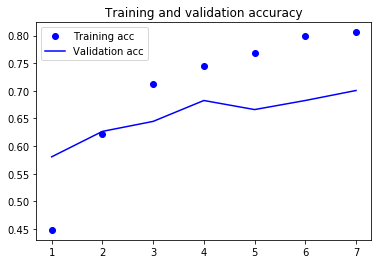

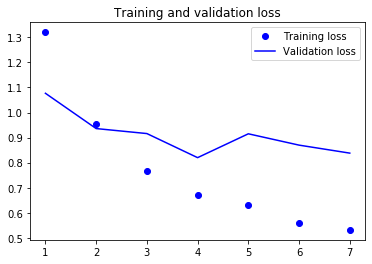

|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.71|0.71|0.71
|Macro|0.74|0.68|0.67


In [78]:
plot_curves(history)
show_scores(model)

## Fine-tuning


**Unfreeze the last layers and train again with lower learning rate**

In [0]:
for layer in conv_base.layers:
  if layer.name.startswith('block14'):
    layer.trainable = True

In [80]:
optimizer = RMSprop(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_10 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 645       
Total params: 21,124,397
Trainable params: 5,011,717
Non-trainable params: 16,112,680
_________________________________________________________________


In [81]:
epochs = 60
callbacks = get_early_stopping_callbacks(5, 'tf_flowers_ft.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 2504 - Training steps per epoch: 78
Validation dataset size: 626 - Validation steps per epoch: 78
Train for 78 steps, validate for 19 steps
Epoch 1/60
78/78 [==============================] - 21s 266ms/step - loss: 0.5649 - accuracy: 0.7929 - val_loss: 0.7690 - val_accuracy: 0.7220
Epoch 2/60
78/78 [==============================] - 18s 225ms/step - loss: 0.4758 - accuracy: 0.8309 - val_loss: 0.7925 - val_accuracy: 0.7089
Epoch 3/60
78/78 [==============================] - 18s 236ms/step - loss: 0.4379 - accuracy: 0.8401 - val_loss: 0.7147 - val_accuracy: 0.7286
Epoch 4/60
78/78 [==============================] - 19s 238ms/step - loss: 0.3872 - accuracy: 0.8702 - val_loss: 0.6905 - val_accuracy: 0.7418
Epoch 5/60
78/78 [==============================] - 18s 229ms/step - loss: 0.3564 - accuracy: 0.8738 - val_loss: 0.7367 - val_accuracy: 0.7401
Epoch 6/60
78/78 [==============================] - 18s 228ms/step - loss: 0.3399 - accuracy: 0.8770 - val_

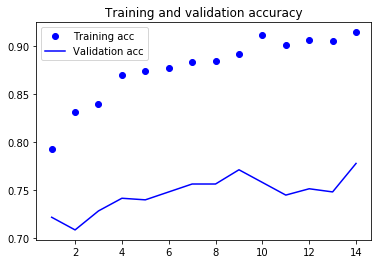

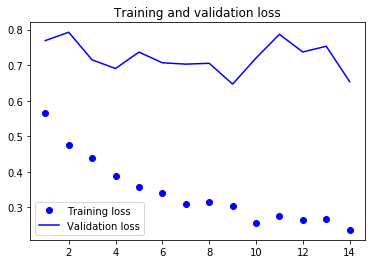

|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.78|0.78|0.78
|Macro|0.80|0.78|0.77


In [82]:
plot_curves(history)
show_scores(model)

# Training from scratch

In [66]:
from tensorflow.keras.applications import Xception

conv_base = Xception(include_top=False, pooling='max')
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(conv_base)
model.add(Dense(5, activation='softmax'))

In [68]:
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(lr=2e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 10245     
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


In [69]:
epochs = 60
callbacks = get_early_stopping_callbacks(10, 'tf_flowers_ft.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 2504 - Training steps per epoch: 78
Validation dataset size: 626 - Validation steps per epoch: 78
Train for 78 steps, validate for 19 steps
Epoch 1/60
78/78 [==============================] - 72s 927ms/step - loss: 0.7472 - accuracy: 0.7236 - val_loss: 0.4410 - val_accuracy: 0.8339
Epoch 2/60
78/78 [==============================] - 64s 823ms/step - loss: 0.3788 - accuracy: 0.8610 - val_loss: 0.2774 - val_accuracy: 0.9079
Epoch 3/60
78/78 [==============================] - 64s 820ms/step - loss: 0.2553 - accuracy: 0.9151 - val_loss: 0.2183 - val_accuracy: 0.9309
Epoch 4/60
78/78 [==============================] - 64s 823ms/step - loss: 0.1965 - accuracy: 0.9303 - val_loss: 0.1937 - val_accuracy: 0.9408
Epoch 5/60
78/78 [==============================] - 64s 823ms/step - loss: 0.1702 - accuracy: 0.9391 - val_loss: 0.1652 - val_accuracy: 0.9457
Epoch 6/60
78/78 [==============================] - 64s 821ms/step - loss: 0.1410 - accuracy: 0.9499 - val_

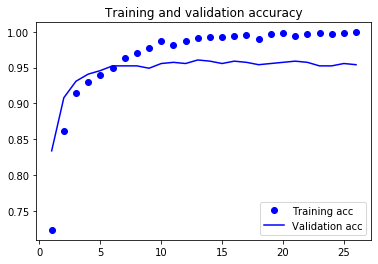

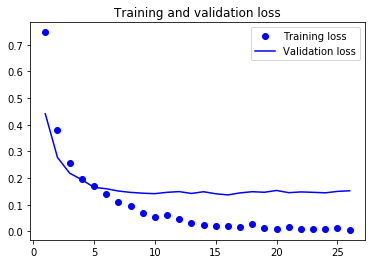

|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.97|0.97|0.97
|Macro|0.97|0.96|0.97


In [70]:
plot_curves(history)
show_scores(model)

# Visualize predictions on test set

Correct predictions: 202 out of 209


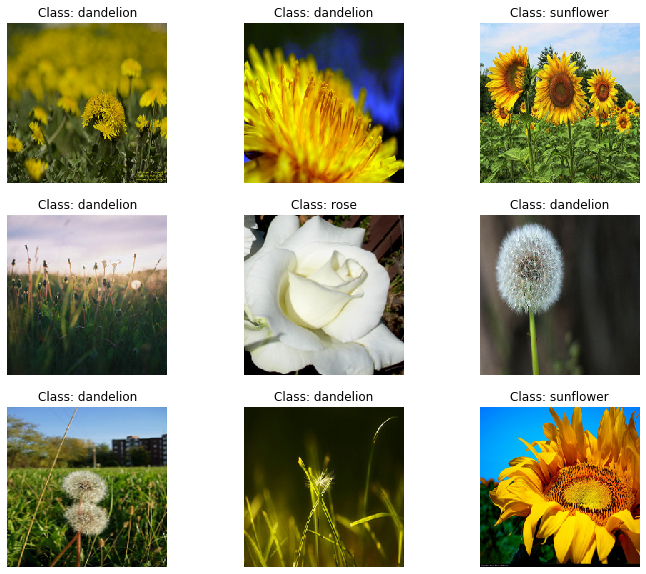

In [71]:
plot_correct_predictions(model)

IndexError: ignored

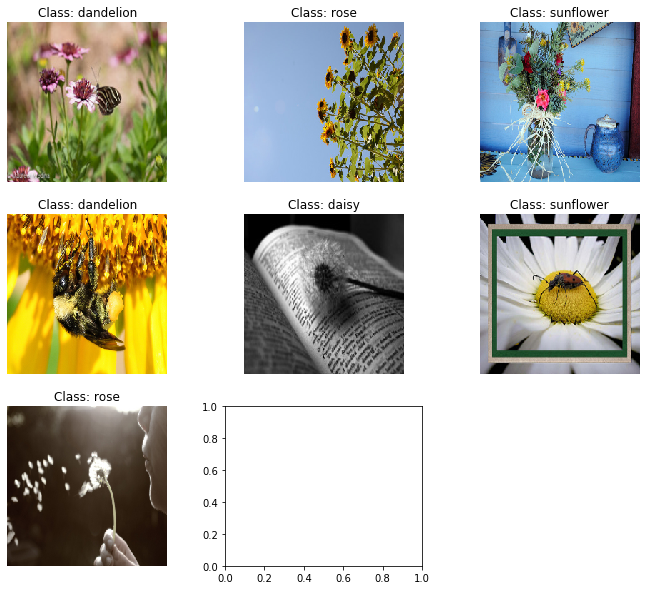

In [72]:
plot_wrong_predictions(model)